## simple debug setup

In [1]:
import os, osr, glob
import xarray as xr
import rioxarray
from rioxarray.merge import merge_datasets
import numpy as np
#
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#
from equi7grid.equi7grid import Equi7Grid
#%matplotlib widget
#%matplotlib inline

In [2]:
# set the tile, row, col, and polarisation  to read:
myTile = 'E078N066T3'
myRow = 9
myCol = 5
myPol = 'VH'

In [3]:
# set the folter wih the output files:
#data_folder = r'/project/return/Share/mm/S1_SA_output_new/E078N066T3/'
#data_folder = r'/project/return/Share/mm/S1_SA_TEST_UPSCALE/' +  'E051N060T3_4cores'
#data_folder = r'/project/return/Share/mm/S1_SA_TEST_UPSCALE/' +  'E078N066T3_allData'
#fileName = myTile + '_' + str(myRow) + '_' + str(myCol) + '_1000_' + myPol + '.nc'
#
#data_folder = r'/project/return/Share/mm/S1_SA_TEST_UPSCALE/' +  'E078N066T3_DescOnly'
#fileName = myTile + '_' + str(myRow) + '_' + str(myCol) + '_1000_' 'DESCENDINGorbits_'+ myPol + '.nc'
#
data_folder = r'/project/return/Share/mm/S1_SA_TEST_UPSCALE/' +  'E078N066T3_OrbitWise'
fileName = myTile + '_' + str(myRow) + '_' + str(myCol) + '_1000_' + 'D039_'+ myPol + '.nc'
#
#data_folder = r'/project/return/Share/mm/S1_SA_TEST_UPSCALE/' +  'E078N066T3_smallChanks'

Reading in case of single row and column:

In [5]:
#fileName = myTile + '_' + str(myRow) + '_' + str(myCol) + '_250_' + 'D039_'+ myPol + '.nc'
my_out = rioxarray.open_rasterio(os.path.join(data_folder, fileName))

Reading in case of multiple row and column:

In [4]:
# Equi7 SA wkt:
PROJ = 'PROJCS["Azimuthal_Equidistant",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.017453292519943295]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["false_easting",7257179.23559],PARAMETER["false_northing",5592024.44605],PARAMETER["central_meridian",-60.5],PARAMETER["latitude_of_origin",-14.0],UNIT["Meter",1.0]]'

In [ ]:
# read multiple ckunks:
ChunkDatasetList = []
# set the rwos and columns:
myCols, myRows = np.meshgrid(np.arange(20, 24), np.arange(36, 40))
# read each one
for myRow, myCol in zip(myRows.flatten(), myCols.flatten()):
    # set filename:
    fileName = myTile + '_' + str(myRow) + '_' + str(myCol) + '_250_' + 'D039_'+ myPol + '.nc'
    aux_ds = rioxarray.open_rasterio(os.path.join(data_folder, fileName))
    # set crs:
    aux_ds.rio.write_crs(PROJ, inplace=True)
    ChunkDatasetList.append(aux_ds)                 

In [ ]:
# mearge spatialy:
my_out = merge_datasets(ChunkDatasetList)   

In [ ]:
my_out

## Total and annual statistics

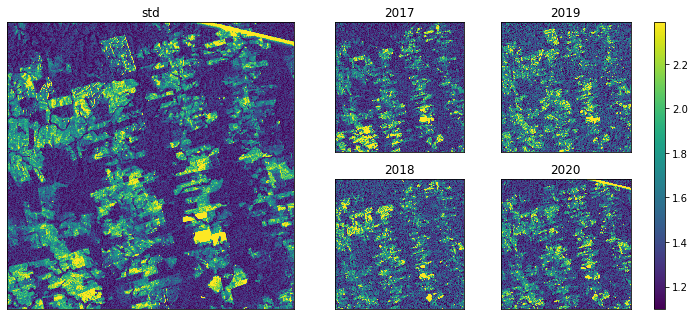

In [8]:
statName = 'std'
# list of local statistics:
years = ['2017', '2018', '2019', '2020']
annualNames = [statName + '_' + year for year in years]

# set limits
my_vmin = np.nanquantile(my_out[statName + '_total'].values.flatten(), 0.02)
my_vmax = np.nanquantile(my_out[statName + '_total'].values.flatten(), 0.98)

fig = plt.figure(figsize=(10, 4.5))

# Setup axes
gs = gridspec.GridSpec(2,5, height_ratios=[1, 1], width_ratios=[1, 1, 1, 1, 0.07])
axs = {}
axs[statName] = fig.add_subplot(gs[0:2,0:2], aspect=1)
axs[years[0]] = fig.add_subplot(gs[0,2], aspect=1)
axs[years[1]] = fig.add_subplot(gs[1,2], aspect=1)
axs[years[2]] = fig.add_subplot(gs[0,3], aspect=1)
axs[years[3]] = fig.add_subplot(gs[1,3], aspect=1)

# Disable axis ticks
for ax in axs.values():
    ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

# Add titles
for name, ax in axs.items():
    ax.set_title(name)   
    
# Total stats
plots = {}
plots[statName] = my_out[statName + '_total'].plot(ax=axs[statName], add_labels=False, add_colorbar=False, vmin=my_vmin , vmax=my_vmax)

# yearly stats
for my_year, my_annName in zip(years, annualNames):
    my_vmin = np.nanquantile(my_out[my_annName].values.flatten(), 0.02)
    my_vmax = np.nanquantile(my_out[my_annName].values.flatten(), 0.98)
    my_out[my_annName].plot(ax=axs[my_year], add_labels=False, add_colorbar=False, vmin=my_vmin , vmax=my_vmax)
    
# Colour bars
cbar_gs = gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=gs[:,4], wspace=2.5)
cax_totalStat = fig.add_subplot(cbar_gs[0,0])
plt.colorbar(plots[statName], cax_totalStat)

fig.tight_layout()

In [ ]:
# total statistics:
statName = 'std'
# list of local statistics:
my_stats = ['mean', 'std', 'MAD', 'max-min', 'q90-q10', 'q75-q25']
# list of coresponding data arrays:
my_dArrays = [my_out['mean_total'],  my_out['std_total'], my_out['MAD_total'], 
              my_out['max_total'] - my_out['min_total'], my_out['q90_total'] - my_out['q10_total'],  
              my_out['q75_total'] - my_out['q25_total']]


fig = plt.figure(figsize=(10, 4.5))

# Setup axes
gs = gridspec.GridSpec(2,6, height_ratios=[1, 1], width_ratios=[1, 0.05, 1, 0.05, 1, 0.05], hspace=0.5, wspace=0.05)
axs = {}
axs[my_stats[0]] = fig.add_subplot(gs[0,0], aspect=1)
axs[my_stats[1]] = fig.add_subplot(gs[0,2], aspect=1)
axs[my_stats[2]] = fig.add_subplot(gs[0,4], aspect=1)
axs[my_stats[3]] = fig.add_subplot(gs[1,0], aspect=1)
axs[my_stats[4]] = fig.add_subplot(gs[1,2], aspect=1)
axs[my_stats[5]] = fig.add_subplot(gs[1,4], aspect=1)



# Disable axis ticks
for ax in axs.values():
    ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

# Add titles
for name, ax in axs.items():
    ax.set_title(name)
    
# total stats
plots = {}
for my_stat, my_dArray in zip(my_stats, my_dArrays):
    # specify limits:
    my_vmin = np.nanquantile(my_dArray.values.flatten(), 0.02)
    my_vmax = np.nanquantile(my_dArray.values.flatten(), 0.98)
    # add plot
    plots[my_stat] =my_dArray.plot(ax=axs[my_stat], add_labels=False, add_colorbar=False, vmin=my_vmin , vmax=my_vmax)

# Colour bars
cbar_gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 1])
cax_totalStat = fig.add_subplot(cbar_gs[0,0])
plt.colorbar(plots[my_stats[0]], cax_totalStat)

cbar_gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 3])
cax_totalStat = fig.add_subplot(cbar_gs[0,0])
plt.colorbar(plots[my_stats[1]], cax_totalStat)

cbar_gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 5])
cax_totalStat = fig.add_subplot(cbar_gs[0,0])
plt.colorbar(plots[my_stats[2]], cax_totalStat)

cbar_gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 1])
cax_totalStat = fig.add_subplot(cbar_gs[0,0])
plt.colorbar(plots[my_stats[3]], cax_totalStat)

cbar_gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 3])
cax_totalStat = fig.add_subplot(cbar_gs[0,0])
plt.colorbar(plots[my_stats[4]], cax_totalStat)

cbar_gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1, 5])
cax_totalStat = fig.add_subplot(cbar_gs[0,0])
plt.colorbar(plots[my_stats[5]], cax_totalStat)

#fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(10, 5.9), sharex=True, sharey=True)
my_DArrays = [my_out.mean_total, my_out.std_total, my_out.MAD_total, 
              my_out.max_total - my_out.min_total,
              my_out.q90_total - my_out.q10_total,
              my_out.q75_total - my_out.q25_total
             ]
# set min, max values
my_mins = []
my_maxs = []
for my_DArray in my_DArrays:
    my_mins.append(np.nanquantile(my_DArray.values.flatten(), 0.02))
    my_maxs.append(np.nanquantile(my_DArray.values.flatten(), 0.98))

# add plots
my_DArrays[0].plot(ax=axs[0, 0], cbar_kwargs={'label': ''}, vmin=my_mins[0], vmax=my_maxs[0])
my_DArrays[1].plot(ax=axs[0, 1], cbar_kwargs={'label': ''}, vmin=my_mins[1], vmax=my_maxs[1])
my_DArrays[2].plot(ax=axs[0, 2], cbar_kwargs={'label': ''}, vmin=my_mins[2], vmax=my_maxs[2])
my_DArrays[3].plot(ax=axs[1, 0], cbar_kwargs={'label': ''}, vmin=my_mins[3], vmax=my_maxs[3])
my_DArrays[4].plot(ax=axs[1, 2], cbar_kwargs={'label': ''}, vmin=my_mins[4], vmax=my_maxs[4])
my_DArrays[5].plot(ax=axs[1, 1], cbar_kwargs={'label': ''}, vmin=my_mins[5], vmax=my_maxs[5])
#
axs[0, 0].set_title('Mean')
axs[0, 1].set_title('Std')
axs[0, 2].set_title('MAD')
axs[1, 0].set_title('MAX-MIN')
axs[1, 1].set_title('Q90-Q10')
axs[1, 2].set_title('Q75-Q25')

#
axs[0, 0].set_aspect('equal', 'box')
axs[0, 0].set_xlabel('')
axs[0, 0].set_ylabel('')
#
axs[0, 1].set_aspect('equal', 'box')
axs[0, 1].set_xlabel('')
axs[0, 1].set_ylabel('')
#
axs[0, 2].set_aspect('equal', 'box')
axs[0, 2].set_xlabel('')
axs[0, 2].set_ylabel('')
#
axs[1, 0].set_aspect('equal', 'box')
axs[1, 0].set_xlabel('')
axs[1, 0].set_ylabel('')
#
axs[1, 1].set_aspect('equal', 'box')
axs[1, 1].set_ylabel('')
axs[1, 1].set_xlabel('')
#
axs[1, 2].set_aspect('equal', 'box')
axs[1, 2].set_ylabel('')
axs[1, 2].set_ylabel('')
#
fig.tight_layout()

In [ ]:
# total statistics:
statName1 = 'q90'
statName2 = 'q10'
statName = statName1 + '-' + statName2
# list of local statistics:
years = ['2017', '2018', '2019', '2020']
annualNames1 = [statName1 + '_' + year for year in years]
annualNames2 = [statName2 + '_' + year for year in years]

fig = plt.figure(figsize=(10, 4.5))

# Setup axes
gs = gridspec.GridSpec(2,5, height_ratios=[1, 1], width_ratios=[1, 1, 1, 1, 0.07])
axs = {}
axs[statName] = fig.add_subplot(gs[0:2,0:2], aspect=1)
axs[years[0]] = fig.add_subplot(gs[0,2], aspect=1)
axs[years[1]] = fig.add_subplot(gs[1,2], aspect=1)
axs[years[2]] = fig.add_subplot(gs[0,3], aspect=1)
axs[years[3]] = fig.add_subplot(gs[1,3], aspect=1)

# Disable axis ticks
for ax in axs.values():
    ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

# Add titles
for name, ax in axs.items():
    ax.set_title(name)   


# set limits
my_vmin = np.nanquantile((my_out[statName1 + '_total'] - my_out[statName2 + '_total']).values.flatten(), 0.02)
my_vmax = np.nanquantile((my_out[statName1 + '_total'] - my_out[statName2 + '_total']).values.flatten(), 0.98)
    
# Total stats
plots = {}
plots[statName] = (my_out[statName1 + '_total'] - my_out[statName2 + '_total']).plot(ax=axs[statName], add_labels=False, add_colorbar=False, vmin=my_vmin , vmax=my_vmax)

# yearly stats
for my_year, my_annName1, my_annName2 in zip(years, annualNames1, annualNames2):
    #my_vmin = np.nanquantile(my_out[my_annName].values.flatten(), 0.02)
    #my_vmax = np.nanquantile(my_out[my_annName].values.flatten(), 0.98)
    (my_out[my_annName1] - my_out[my_annName2]).plot(ax=axs[my_year], add_labels=False, add_colorbar=False, vmin=my_vmin , vmax=my_vmax)
    
# Colour bars
cbar_gs = gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=gs[:,4], wspace=2.5)
cax_totalStat = fig.add_subplot(cbar_gs[0,0])
plt.colorbar(plots[statName], cax_totalStat)

fig.tight_layout()

In [ ]:
(my_out.count_2020).plot(figsize=(10, 8))

In [ ]:
my_da = my_out.q90_total - my_out.q10_total
#
my_vmin = np.nanquantile(my_da.values.flatten(), 0.02)
my_vmax = np.nanquantile(my_da.values.flatten(), 0.98)
#
my_da.plot(figsize=(10, 8), vmin=my_vmin, vmax=my_vmax)

## Plot consequtive years of decrease

In [ ]:
annMeans = my_out[['mean_2017', 'mean_2018', 'mean_2019', 'mean_2020']]

In [ ]:
myMeans = annMeans.mean_2017.sel(band=1).values
myMeans = np.expand_dims(myMeans, axis=2)

In [ ]:
allMeans = np.concatenate((myMeans, 
                           np.expand_dims(annMeans.mean_2018.sel(band=1).values, axis=2), 
                           np.expand_dims(annMeans.mean_2019.sel(band=1).values, axis=2), 
                           np.expand_dims(annMeans.mean_2020.sel(band=1).values, axis=2)), axis=2)

In [ ]:
allMeans.shape

In [ ]:
meanDrop = np.apply_along_axis(lambda x: np.sum(np.diff(x)<0), 2, allMeans)

In [ ]:
%matplotlib widget
#%matplotlib inline
# mask where the man is droping:
meanDrop_mask = np.ma.masked_where(meanDrop == 3, meanDrop + 0.5)
# plot it:
plt.imshow(meanDrop_mask, cmap='gray')
plt.colorbar()

## Time seres break detection results

In [ ]:
# eception label selection:
# 0 - tipical disturbance (including aklso no recovery!!! see TS_end_flag and TS_end_flag_long)
# 1 - no data
# 2 - no disturbance
# 3 - atipical disturbance (mean TS is above the refernce bounds)
# -------------------------------------------------------------------
my_out_lab3 = my_out.where(my_out.exception_label==0)
my_out_lab3.error_margin.plot(figsize=(10, 8))

In [ ]:
#%matplotlib widget
#%matplotlib inline
#
# eception label selection:
# 0 - tipical disturbance (including aklso no recovery!!! see TS_end_flag and TS_end_flag_long)
# 1 - no data
# 2 - no disturbance
# 3 - atipical disturbance (mean TS is above the refernce bounds)
# -------------------------------------------------------------------------------
my_out.exception_label.plot(figsize=(10, 8), levels=[0, 1, 2, 3, 4])

In [ ]:
my_out.where((my_out.exception_label==3) | ((my_out.exception_label==0) & (my_out.max_mag>3)))\
    .exception_label.plot(figsize=(10, 8), levels=[0, 1, 2, 3, 4])

In [ ]:
#feature_da = my_out.where((my_out.exception_label==3) | ((my_out.exception_label==0) & (my_out.max_mag>3)))
feature_da = my_out.where((my_out.exception_label==0) & (my_out.max_mag>3) & (my_out.TS_end_flag>-2))
#%matplotlib widget
%matplotlib inline
feature_da.max_mag_date.plot(figsize=(10, 8), levels=[2018, 2019, 2020, 2021])

In [ ]:
# export to tiff:
#feature_da.max_mag_date.rio.to_raster("D039_max_time_with_mag_lt3.tif")

# Histogram analysis

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
bb = feature_da[['t_total', 'max_mag_org']]
g = sns.jointplot(data=bb.to_dataframe(), x="t_total", y="max_mag_org", marker="+")
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)

In [ ]:
bb1 = bb.where(bb.t_total<600)

In [ ]:
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=bb1.to_dataframe(), x="t_total", y="max_mag_org", s=5, color=".15")
sns.histplot(data=bb1.to_dataframe(), x="t_total", y="max_mag_org", bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(data=bb1.to_dataframe(), x="t_total", y="max_mag_org", levels=5, color="w", linewidths=1)